# 10 Years of Crowdfunding on Kickstarter Exploratory Analysis
## by Marie-Luise Klaus

## Investigation Overview

This exploratory data analysis is dedicated to the 10th anniversary of the crowdfunding platform Kickstarter in April 2019. 
The main goal is to analyse current trends and determine possible factors contributing to the success of a campaign. 

Throughout the course of this notebook, I will have two main questions in mind. Based on our data:

**1) Is it still worthwile financing your project on Kickstarter, now that crowdfunding has become mainstream?**  
**2) What determines the success of a crowdfunding campaign on Kickstarter?**



## Dataset Overview

The Kickstarter data set was gathered in April 2019 from an automated web scraping service called Web Robots. They publish monthly data on all ongoing and completed Kickstarter projects and released it to the public in the form of csv files on their website. 

https://webrobots.io/kickstarter-datasets/

After assessing and cleaning the data, I was left with information on 10 years of Kickstarter campaigns, from Kickstarter's launch in April 2009 to April 2019. The focus of my analysis was the remaining 169,661 observations. As for the features of this dataset, 22 variables were selected for analysis. The main feature that I explored was the status of a project. It depicts whether the crowdfunding was a success or failure. Supported was this by investigating how project characteristics were associated with the success of a campaign. In the course of this analysis, I suspect the following factors will be the most influential on a project: the funding goal, successfully pledged dollars, the number of backers, the promotional support provided by Kickstarter, the dates of campaigns and the project category.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")
sns.set_style("whitegrid")

In [2]:
# read in 4 files and concatinate the data into a single pandas data frame
file_name =  './data/kickstarter_master{}.csv'
master_df = pd.concat([pd.read_csv(file_name.format(i)) for i in range(1,5)])
master_df.reset_index(drop=True, inplace=True)

In [3]:
# convert time data to date time format
master_df[['created_at', 'launched_at', 'state_changed_at', 'deadline', 'last_update_at']] = master_df[['created_at', 'launched_at', 'state_changed_at', 'deadline', 'last_update_at']].apply(pd.to_datetime)

# engineer variable to asses funding duration
master_df['duration'] = master_df['deadline'] - master_df['launched_at']
# convert duration time delta to float of days
master_df['duration_days'] = (master_df['duration'].astype('timedelta64[h]') / 24)

# create combined category
master_df['comb_cat'] = master_df['category'] + "/" + master_df['subcategory']
master_df[['category', 'subcategory','comb_cat']].sample(5)

# create a separate data frame for completed projects only
ks_compl = master_df.query('(status == "successful") | (status == "failed")')
ks_compl.reset_index(drop=True, inplace=True)
ks_compl.status.value_counts()

# remove features that are irrelevant to this presentation to keep our dataframe neat
ks_compl = ks_compl.drop(labels=['project_name', 'url', 'blurb', 'image', 'slug', 'created_at', 'last_update_at', 
                                 'creator_id', 'creator_name', 'country', 'city', 'state', 'displ_loc',
                                 'loc_type', 'currency', 'state_changed_at', 'launched_at',
                                 'goal_real', 'goal_current_usd','pledged_real', 'pledged_current_usd', 
                                 'current_fx_rate(usd)', 'hist_exchange_rate(usd)', ], axis=1)

In [4]:
# utility to improve readability of large numbers 
def format_num(num):
    num = round(float(num))
    formatted_num = str(num)
    str_length = len(formatted_num)
    cursor = str_length % 3
    if str_length > 3 and cursor > 0:
        formatted_num = formatted_num[0:cursor] + "," + formatted_num[cursor:] 
        cursor += 1
        str_length = str_length - cursor
    while str_length > 3:
        formatted_num = formatted_num[0:cursor+3] + "," + formatted_num[cursor+3:]
        cursor += 4
        str_length -= 3
    return formatted_num

In [5]:
# utility to format yticks
def format_yticks(maximum, step, minimum=0):
    ylocs = np.arange(minimum, maximum+step, step)
    ylabels = [format_num(yloc) for yloc in ylocs]
    plt.yticks(ylocs, ylabels)
    
# utility to format xticks
def format_xticks(maximum, step, minimum=0):
    xlocs = np.arange(minimum, maximum+step, step)
    xlabels = [format_num(xloc) for xloc in xlocs]
    plt.xticks(xlocs, xlabels)

In [6]:
# utility to create xticks for a timeline 
def timeline_ticks(df):    
    x_labels = np.arange('2009-05', '2019-05', 7, dtype='datetime64[M]')
    x_ticks = np.arange(0,len(df), 7)
    plt.xticks(x_ticks,x_labels, rotation=45, ha='right')
    plt.xlabel("")

In [7]:
# remove outlier projects with extremely high goals, pledges or backers counts 
# to make visualization and interpretation possible

# identify goal quartiles and 95% quantile of each skewed feature
goal_min = ks_compl.goal_hist_usd.min()
goal_25 = ks_compl.goal_hist_usd.quantile(q=0.25)
goal_50 = ks_compl.goal_hist_usd.quantile(q=0.5)
goal_75 = ks_compl.goal_hist_usd.quantile(q=0.75)
goal_95 = ks_compl.goal_hist_usd.quantile(q=0.95)
goal_975 = ks_compl.goal_hist_usd.quantile(q=0.975)
goal_outliers = ks_compl.goal_hist_usd.quantile(q=0.9999)
goal_max = ks_compl.goal_hist_usd.max()
pledged_95 = ks_compl.pledged_hist_usd.quantile(q=0.95)
backers_95 = ks_compl.backers_count.quantile(q=0.95)

# bin observations into ordinal goal categories
bin_edges = [0, goal_25, goal_50, goal_75, goal_95, goal_975, goal_outliers, goal_max]
bin_names = ['low', 'medium', 'moderately high', 'high', 'very high', 'extreme', 'outliers']

# create a column to classify campaigns by goal level 
pd.set_option('mode.chained_assignment', None)
ks_compl['goal_level'] = pd.cut(ks_compl['goal_hist_usd'], bin_edges, labels=bin_names)

ks_compl_95 = ks_compl.copy()
print("Projects completed : ", format_num(len(ks_compl_95)))

# select all projects that stay below the 95% quantiles in goal, pledged and backers 
ks_compl_95 = ks_compl_95.query('(goal_hist_usd < @goal_95) & \
                                  (pledged_hist_usd < @pledged_95) & \
                                  (backers_count < @backers_95)')

ks_compl_95.reset_index(drop=True, inplace=True)
print("After removal of outliers: ", format_num(len(ks_compl_95)))

# create separate data frames without outlier for successful and failed projects
ks_success_95 = ks_compl_95[ks_compl_95.status == 'successful']
ks_fail_95= ks_compl_95[ks_compl_95.status == 'failed']
print("No. success projects 95%.: ", format_num(len(ks_success_95)), \
      "\nNo. failed projects 95%.:", format_num(len(ks_fail_95)))

Projects completed :  169,661
After removal of outliers:  151,754
No. success projects 95%.:  84,581 
No. failed projects 95%.: 67,173


In [8]:
# create separate data frames for successful and failed projects
ks_compl_success = ks_compl[ks_compl.status == "successful"]
ks_compl_failed = ks_compl[ks_compl.status == "failed"]

# frequently used variables 
dates = np.arange('2009-05', '2019-05', dtype='datetime64[M]')
months = ["July", "August", "September",
         "October", "November", "December", "January", 
         "February", "March", "April", "May", "June"]

# define commonly used colors
cust_green = '#66cdaa'
cust_red = '#f08080'
cust_blue = '#43a2ca'
status_colors = [cust_blue, cust_green, cust_red]
fill_red = '#fee0d2'
fill_green = '#e0f3db'
backers_color = '#a6611a'
pledged_color = "#c994c7"
goal_color =  sns.color_palette("Blues_r")[0]
feat_color = sns.color_palette("Set1")
category_colors = ['#a6cee3','#e5c494', '#1f78b4', '#33a02c', '#fb9a99', '#b3b3b3', '#e31a1c','#fdbf6f', 
                   '#ff7f00', '#cab2d6', '#6a3d9a', '#b2df8a', '#984ea3', '#ffd92f', '#b15928']

# Is it still worthwile financing your project on Kickstarter, now that crowdfunding has become mainstream?

In recent years, crowdfunding became popular as a form of capital investment to fund any kind of ventures. With more competition, campaign creators likely face bigger challenges courting for attention and investment. Additionally, media often enough reported scams which may have deterred potential supporters from pledging their money. 

I'm curious how its popularity and the saturated market affected campaigns. With thousands of campaigns competing against each other globally, we would expect lower chances of success today. Than it would also make sense for project creators to realize lower fundraising capital goals.     

In the following analysis, I'm going to investigate how crowdfunding as an investment opportunity on Kickstarter has evolved over time. My goal is to find an answer if running a campaign today pays off compared to previous years. Did the overall conditions worsen due to the Kickstarter's popularity? How may have campaign characteristics changed on Kickstarter's 10th anniversary, compared to previous years?

## The number of monthly campaigns has been growing again since 2018

After a rather slow growth in the first 5 years after Kickstarter's launch, crowdfunding activities exploded in August 2014 and again in March/April 2015. Project counts settled down thereafter. Nevertheless, with roughly 2k new projects each month, activities remained on a high level up until today. Since 2018, the number of campaigns ending each month have been increasing notably.

**In 2018, 63.5% of campaigns were successful.**    

With the hype of Kickstarter in late 2014, we found an abnormally high percentage of failed projects. 61% flopped. During the years of recession the likelihood of failing minimally exceeded the success rates. 51% of projects failed. By the beginning of 2018, Kickstarter turned success and failure rates upside down. On average, 63.5% of completed campaigns had the chance to succeed. Actually, the record for successful campaigns was set only recently, in March 2019. Chances of winning were 74%!

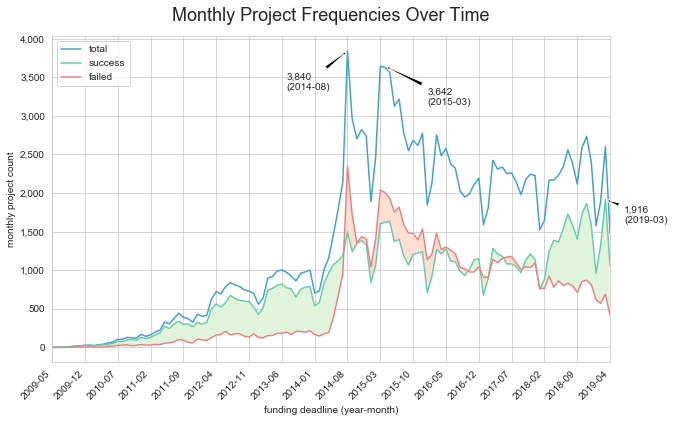

In [9]:
# create dataframe to summarize project counts per month over the course of 120 months
df_project_counts = pd.DataFrame(data={'total': [0.0]*120, 
                              'success':  [0.0]*120, 
                              'failed':  [0.0]*120, 
                              'date': dates})

# fill data frame with absolute project counts per month
for df, label in [(ks_compl, 'total'), (ks_compl_success, 'success'), (ks_compl_failed, 'failed')]:
    # calculate monthly abs. project counts
    counts = df.groupby([df.deadline.dt.year, df.deadline.dt.month])\
                        .count()['project_id']
    # the above grouping ignores months with zero counts, so we manually add zero values
    # re-create a new multi-index, this time including all 12 months per year
    levels = [counts.index.levels[0].values, range(1,13)]
    new_index = pd.MultiIndex.from_product(levels, names=['year', 'month'])
    # re-index counts and fill empty values with zero
    counts = counts.reindex(new_index, fill_value=0).values
    # remove months Jan-April 2014 and, May-Dec 2019 
    counts = counts[4:-8]
    # add to dataframe
    df_project_counts[label] = counts

# settings
plt.figure(figsize=[10,6])

# plot monthly counts of projects of completed projects by month over time
for i, col in enumerate(df_project_counts.columns[:-1]):
    ax = df_project_counts[col].plot(color=status_colors[i])

# annotate peaks
ymax_1  = max(df_project_counts.total)
xmax_1 = str(df_project_counts[df_project_counts.total == ymax_1].date.values[0])[:7]
ax.annotate(format_num(ymax_1) + "\n(" + str(xmax_1) + ")", xy=(63, ymax_1), 
            xytext=(50, ymax_1-500),
            arrowprops=dict(facecolor='black', arrowstyle="fancy"))

ymax_2  = df_project_counts.total.sort_values().values[-2]
xmax_2 = str(df_project_counts[df_project_counts.total == ymax_2].date.values[0])[:7]
ax.annotate(format_num(ymax_2) + "\n(" + str(xmax_2) +")", xy=(71, ymax_2), 
            xytext=(80, ymax_2-500),
            arrowprops=dict(facecolor='black', arrowstyle="fancy"))

ymax_3  = max(df_project_counts.success)
xmax_3 = str(df_project_counts[df_project_counts.success == ymax_3].date.values[0])[:7]
ax.annotate(format_num(ymax_3) + "\n(" + str(xmax_3)+")", xy=(118, ymax_3), 
            xytext=(122, ymax_3-300),
            arrowprops=dict(facecolor='black', arrowstyle="fancy"))


# highlight differences
ax.fill_between(np.arange(0,120), df_project_counts.success, df_project_counts.failed , 
                where=df_project_counts.failed >= df_project_counts.success, 
                facecolor=fill_red, interpolate=True)
ax.fill_between(np.arange(0,120), df_project_counts.success, df_project_counts.failed, 
                where=df_project_counts.success >= df_project_counts.failed, 
                facecolor=fill_green, interpolate=True)

# # labels and titles
plt.title("Monthly Project Frequencies Over Time", fontsize=18, pad=15)

ylabels = ['{:,.0f}'.format(ytick) for ytick in ax.get_yticks()]
ax.set_yticklabels(ylabels)
plt.ylabel('monthly project count')

timeline_ticks(df_project_counts)
plt.xlabel('funding deadline (year-month)')

plt.legend(loc=2)
plt.show()

## Funding goals of successful campaigns have become lower
I noticed a trend of declining funding goals of successful projects since 2017. While successful projects realized goals of roughly USD 3,100 between 2014 - 2016, creators today usually aimed for goals USD 500 lower. 

Compared to failed campaigns, successful goals have been relatively balanced over the entire time. In contrast, the median goals of failed campaigns increased over the years. Only in 2018 they came to an halt. On Kickstarter's anniversary, failed campaigns sought 3 times higher goals.

In [10]:
def group_data_monthly(feature, median=True):
    if median:
        # total
        grouped = ks_compl_95.groupby([ks_compl_95.deadline.dt.year, 
                                       ks_compl_95.deadline.dt.month]).median()[feature].values
        # success
        grouped_s = ks_success_95.groupby([ks_success_95.deadline.dt.year, 
                                           ks_success_95.deadline.dt.month]).median()[feature].values
        # failed
        grouped_f= ks_fail_95.groupby([ks_fail_95.deadline.dt.year, 
                                      ks_fail_95.deadline.dt.month]).median()[feature].values
    else:
        # total
        grouped = ks_compl_95.groupby([ks_compl_95.deadline.dt.year, 
                                       ks_compl_95.deadline.dt.month]).mean()[feature].values
        # success
        grouped_s = ks_success_95.groupby([ks_success_95.deadline.dt.year, 
                                           ks_success_95.deadline.dt.month]).mean()[feature].values
        # failed
        grouped_f= ks_fail_95.groupby([ks_fail_95.deadline.dt.year, 
                                       ks_fail_95.deadline.dt.month]).mean()[feature].values
    # insert 0 occurence for 2009-6
    grouped_f = np.insert(grouped_f,1,0) 
        
    # create dataframe
    df = pd.DataFrame(data={'total':grouped, 
                            'success':grouped_s, 
                            'failed': grouped_f, 
                            'date': dates})
    return df

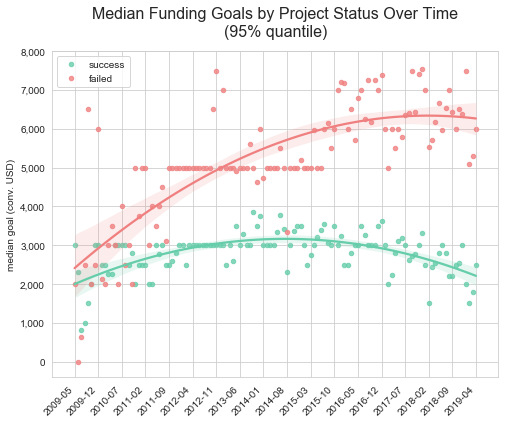

In [11]:
# settings
plt.figure(figsize=[8,6])

# calculate monthly median goals of completed projects of 95 quantile data frame
df_goals = group_data_monthly('goal_hist_usd')

# overwrite date because seabrorn can't plot dates 
df_goals['date'] = np.arange(0, len(df_goals), 1)

# scatterplots of monthly means and fit a polynomial regression of 2nd degree
ax = sns.regplot(x=df_goals['date'], y=df_goals['success'],
                 color=cust_green,
                 scatter_kws={"s": 20},
                 order=2, ci=95, truncate=True, label="success");
ax = sns.regplot(x=df_goals['date'], y=df_goals['failed'],
                 color=cust_red,
                 scatter_kws={"s": 20},
                 order=2, ci=95, truncate=True, label="failed");

# ticks and labels
timeline_ticks(df_goals)
format_yticks(8000, 1000)
plt.ylabel("median goal (conv. USD)")
plt.title("Median Funding Goals by Project Status Over Time\n(95% quantile)", fontsize=16, pad=15)
plt.legend()
plt.show()

## The collected financial backing has been stable
In spite of goals of successful projects being lower nowadays, the overall financial backing per project has been relatively constant since 2014. Recently, the total collected funding even increased slightly. While creators raised a median of USD 5,038 between 2014-2017, they realized USD 5,371 in 2018.

However, if we turn our attention to the plot on right, we notice an extreme discrepancy between goals and pledges. When Kickstarter suddenly boomed in August 2014, the total funding capacity of all completed projects dropped from more than USD 3k down to USD 146. Obviously, the total funding capacity available couldn't keep up pace with the growth of project numbers. 
This gap has been slowly closing. Today, the total funding capacity has almost caught up with the sum of completed project goals. In theory, it won't take long until all goal requirements could be met, if this trend continues. 

The most astonishing about the goal-pledges overhead is that successful campaigns were hardly affected by the lack of funding. We can only speculate, that maybe the additional projects brought by the hype were generally not suitable for crowdfunding or the type of campaigns were irrelevant for supporters, so that lost investment dollars were contained.     

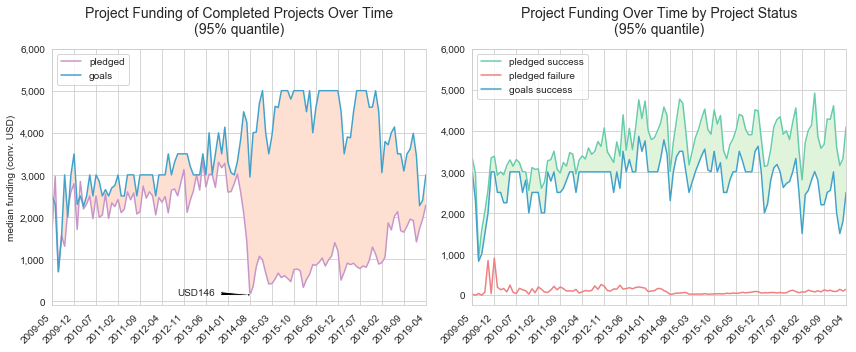

In [12]:
# settings
plt.figure(figsize=[12,5])

# calculate monthly median pledges of completed projects of 95 quantile data frame
df_pledged_median = group_data_monthly('pledged_hist_usd')

# # left plot: line plot of monthly median pledges of all completed projects
plt.subplot(1,2,1)
ax = df_pledged_median.total.plot(color=pledged_color, label='pledged');
ax = df_goals.total.plot(color=cust_blue, label='goals');

# highlight negative differences
ax.fill_between(np.arange(0,120), df_pledged_median.total, df_goals.total , 
                where=df_goals.total >= df_pledged_median.total, 
                facecolor=fill_red, interpolate=True)

# annotate minima
ymin  = min(df_pledged_median.total)
xmin = str(df_pledged_median[df_pledged_median.total == ymin].date.values[0])[:7]
ax.annotate("USD" + format_num(ymin), xy=(64, ymin), 
            xytext=(40, ymin),
            arrowprops=dict(facecolor='black', arrowstyle="fancy"))

# ticks and labels
plt.xlabel("")
timeline_ticks(df_pledged_median)
plt.tight_layout()
format_yticks(6000,1000)
plt.ylabel("median funding (conv. USD)")
plt.title("Project Funding of Completed Projects Over Time\n(95% quantile)", fontsize=14, pad=15)
plt.legend(loc=2)

# right plot: line plots of monthly median pledged of successful anf failed projects
plt.subplot(1,2,2)
ax = df_pledged_median.success.plot(color=cust_green, label="pledged success");
ax = df_pledged_median.failed.plot(color=cust_red, label="pledged failure");
# add goals to compare
ax = df_goals.success.plot(color=cust_blue, label='goals success');

# highlight overhead
ax.fill_between(np.arange(0,120), df_pledged_median.success, 
                df_goals.success , where=df_pledged_median.success >= df_goals.success, 
                facecolor=fill_green, interpolate=True)

# ticks and labels
plt.xlabel("")
timeline_ticks(df_pledged_median)
format_yticks(6000,1000)
plt.ylabel("")
plt.title("Project Funding Over Time by Project Status\n(95% quantile)", fontsize=14, pad=15)
plt.tight_layout()
plt.legend()
plt.show()

## Today supporters tend to pledge smaller amounts.
The money each supporter spent on incentives has been declining lately, creators had to attract a higher number of supporters to collect the same amount of funding. In 2018, successful projects on average collected USD 7 less per backer than in the record year of 2016. This may be a negative development for some creators, but it may also be a strategic chance for business starters to increase their reach, funding or customer numbers.   

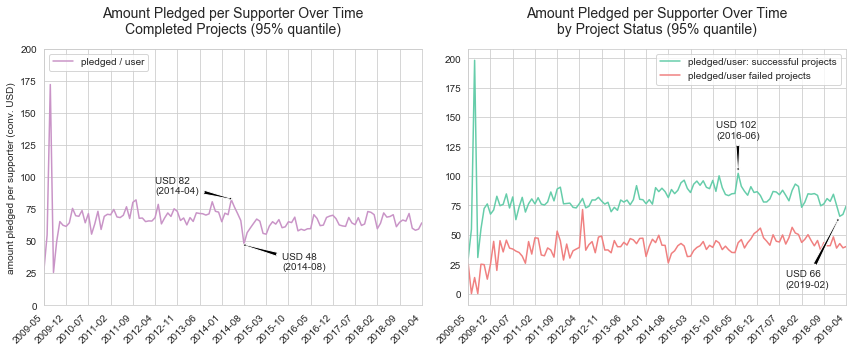

In [13]:
# settings
plt.figure(figsize=[12,5])

# add the average amount pledged per supporter to each campaign of the 95% quantile data
for df in [ks_compl_95, ks_success_95, ks_fail_95]:
    df['pledged_rate'] = (df['pledged_hist_usd'] / df['backers_count']).fillna(0)

# calculate monthly median pledged rate of completed projects of 95 quantile data frame
df_pledged_rate = group_data_monthly('pledged_rate', False)

# # left plot: line plot of monthly relative pledges for all completed projects
plt.subplot(1,2,1)
ax = df_pledged_rate.total.plot(color=pledged_color, label='pledged / user');

# annotate peaks
# peak in 4/2014
ymax_1  = ks_compl_95.groupby([ks_compl_95.deadline.dt.year, 
                              ks_compl_95.deadline.dt.month])['pledged_rate']\
                              .mean().sort_values().values[-2]
xmax_1 = str(df_pledged_rate[df_pledged_rate.total == ymax_1].date.values[0])[:7]
ax.annotate("USD " + format_num(ymax_1)  + "\n(" + str(xmax_1) +")", xy=(60, ymax_1), 
            xytext=(35, ymax_1+5),
            arrowprops=dict(facecolor='black', arrowstyle="fancy"))

# low in 08/2014
ymin = ks_compl_95.groupby([ks_compl_95.deadline.dt.year, 
                            ks_compl_95.deadline.dt.month])['pledged_rate']\
                            .mean().sort_values().values[2]
xmin = str(df_pledged_rate[df_pledged_rate.total == ymin].date.values[0])[:7]
ax.annotate("USD " + format_num(ymin)  + "\n(" + str(xmin) +")", xy=(62, ymin), 
            xytext=(75, ymin-20),
            arrowprops=dict(facecolor='black', arrowstyle="fancy"))

# ticks and labels
plt.xlabel("")
timeline_ticks(df_pledged_rate)

# improve readability of y ticks
plt.yticks(np.arange(0, 201, 25))
plt.ylabel("amount pledged per supporter (conv. USD)")
plt.title("Amount Pledged per Supporter Over Time\nCompleted Projects (95% quantile)", fontsize=14, pad=15)
plt.legend(loc=2)

# right plot: line plot of onthly relative pledges, divided into successful anf failed projects
plt.subplot(1,2,2)
ax = df_pledged_rate.success.plot(color=cust_green, label="pledged/user: successful projects");
ax = df_pledged_rate.failed.plot(color=cust_red, label="pledged/user failed projects");

# annotate peaks
# peak in 6/2016
ymax_3  = ks_success_95.groupby([ks_success_95.deadline.dt.year, 
                              ks_success_95.deadline.dt.month])['pledged_rate']\
                              .mean().sort_values().values[-2]
xmax_3 = str(df_pledged_rate[df_pledged_rate.success == ymax_3].date.values[0])[:7]
ax.annotate("USD " + format_num(ymax_3)  + "\n(" + str(xmax_3) +")", xy=(85, ymax_3), 
            xytext=(78, ymax_3+30),
            arrowprops=dict(facecolor='black', arrowstyle="fancy"))

# low in 08/2014
ymin_2 = ks_success_95.groupby([ks_success_95.deadline.dt.year, 
                              ks_success_95.deadline.dt.month])['pledged_rate']\
                              .mean().sort_values().values[5]
xmin_2 = str(df_pledged_rate[df_pledged_rate.success == ymin_2].date.values[0])[:7]
ax.annotate("USD " + format_num(ymin_2)  + "\n(" + str(xmin_2) +")", xy=(117, ymin_2), 
            xytext=(100, ymin_2-60),
            arrowprops=dict(facecolor='black', arrowstyle="fancy"))

# ticks and labels
plt.xlabel("")
timeline_ticks(df_pledged_rate)
plt.ylabel("")
plt.yticks(np.arange(0, 201, 25))
plt.title("Amount Pledged per Supporter Over Time\nby Project Status (95% quantile)", fontsize=14, pad=15)
plt.tight_layout()
plt.legend()
plt.show()

## Growing supporter numbers compensated for increased competition among creators.
We would expect the recent increase in competing projects, lower funding goals and the tendency to pledge greedier to negatively impact campaigns. However, with Kickstarter becoming mainstream, the number of people who supported a project has been increasing at a faster rate than the number of active campaigns. While a lack of supporters caused severe failure rates during the hype years, the backer/project ratio has been increasing since 2015. Therefore, success rates and the overall funding capacity has been stabilizing. In October 2018, there was even a record median of 72 backers supporting each project.

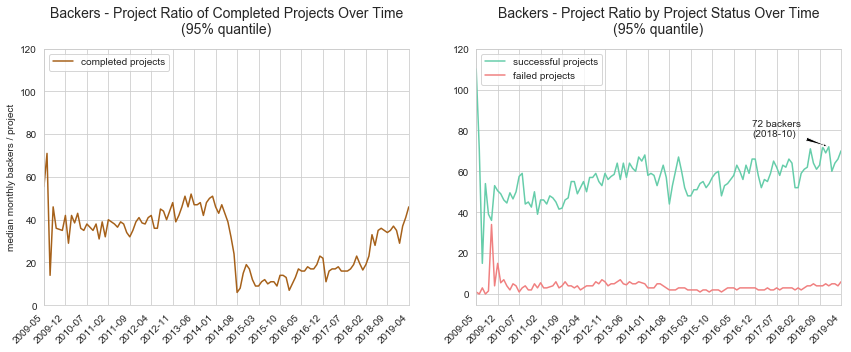

In [14]:
# settings
plt.figure(figsize=[12,5])

# calculate monthly median pledged rate of completed projects of 95 quantile data frame
df_backers_r = group_data_monthly('backers_count')

# left plot: line plot of median backers by completed projects
plt.subplot(1,2,1)
ax = df_backers_r.total.plot(color=backers_color, label='completed projects');

# ticks and labels
plt.xlabel("")
timeline_ticks(df_backers_r)
plt.yticks(np.arange(0, 121, 20))

plt.ylabel("median monthly backers / project")
plt.title("Backers - Project Ratio of Completed Projects Over Time\n(95% quantile)", fontsize=14, pad=15)
plt.legend(loc=2)

# right plot: line plots of avg backers by successful or failed project
plt.subplot(1,2,2)
ax = df_backers_r.success.plot(color=cust_green, label="successful projects");
ax = df_backers_r.failed.plot(color=cust_red, label="failed projects");

# annotate recent maximum
ymax_1  = df_backers_r.success.sort_values().values[-3]
xmax_1 = str(df_backers_r[df_backers_r.success == ymax_1].date.values[0])[:7]
ax.annotate(format_num(ymax_1)+ " backers\n(" + str(xmax_1)+")", xy=(115, ymax_1), 
            xytext=(90, ymax_1+5),
            arrowprops=dict(facecolor='black', arrowstyle="fancy"))

# ticks and labels
plt.xlabel("")
timeline_ticks(df_backers_r)
plt.yticks(np.arange(0, 121, 20))
plt.ylabel("")
plt.title("Backers - Project Ratio by Project Status Over Time\n(95% quantile)", fontsize=14, pad=15)
plt.tight_layout()
plt.legend(loc=2)
plt.show()

## Better chances to be promoted by Kickstarter
Since early 2018 and despite the growing campaign numbers, Kickstarter has been promoting a higher percentage of projects on their landing page (and possibly social channels). Today, more than 60% of all fundings are spotlighted on Kickstarter's channels. The proportion of unsupported projects has decreased from 55% in the hype years to only 27% today.   

Additionally, more projects than ever are additionally picked by staff to be awarded the "Projects We Love" badge as the proportion of fully supported projects has kept constant at a rate of 10%.

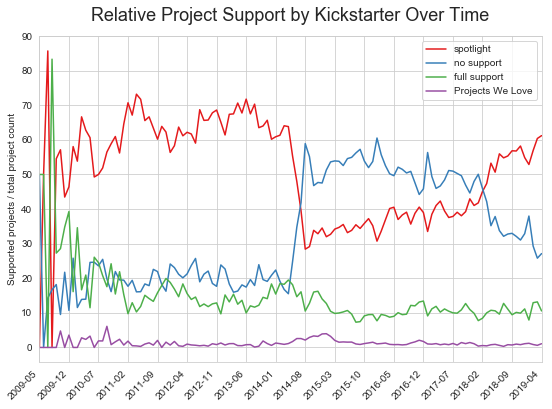

In [15]:
# create empty dataframe
df_featured = pd.DataFrame(data={'no support': [0.0]*120,
                                'Projects We Love': [0.0]*120, 
                                'spotlight': [0.0]*120, 
                                'full support': [0.0]*120, 
                                'date': dates})

# fill data frame with absolute project counts of every feature
for label, df in ks_compl.groupby([ks_compl.featured]):
    # calculate monthly abs. project counts
    counts = ks_compl[ks_compl.featured == label].groupby([ks_compl.deadline.dt.year, 
                                                           ks_compl.deadline.dt.month]).size()
    # the above grouping ignores months with zero counts, so we manually add zero values
    # re-create a new multi-index, this time including all 12 months per year
    levels = [counts.index.levels[0].values, range(1,13)]
    new_index = pd.MultiIndex.from_product(levels, names=['year', 'month'])
    # re-index counts and fill empty values with zero
    counts = counts.reindex(new_index, fill_value=0).values
    # remove months Jan-April 2014 and, May-Dec 2019 
    counts = counts[4:-8]
    # add to dataframe
    df_featured[label] = counts
    
# calculate relative project support by dividing featured project counts by monthly project counts
for label in ks_compl.featured.value_counts().index:
    df_featured[label] = (df_featured[label] / df_project_counts['total'])*100
    
# Visualize how Kickstarter supported projects over time in relative values
# settings
plt.figure(figsize=[9,6])

# plot each featured value on a line 
for label in ks_compl.featured.value_counts().index:
    ax = df_featured[label].plot(color=sns.set_palette(feat_color),label=label);
    
# ticks and labels
timeline_ticks(df_featured)
plt.xlabel("")

plt.yticks(np.arange(0, 90+10, 10))
plt.ylabel("Supported projects / total project count");

plt.title("Relative Project Support by Kickstarter Over Time", fontsize=18, pad=15);
plt.legend()
plt.show()

# 2) What determines the success of a crowdfunding campaign on Kickstarter?
To determine whether a campaign was considered successful or not, we looked into two main factors: first,the general chance of successfully ending a campaign, and second, the amount of funding that was ultimately collected. 
When creators decide on a goal, they generally have to consider whether to maximize their chances to successfully end a campaign or to generate the maximum funding possible. Both targets oppose each other diametrically. Because of Kickstarter's all-or-nothing-approach, raising the goal typically decreases the chances to succeed, yet creators risk insufficient funding by aiming for low goals.

## Goals

Let's understand the distribution of goals first. There is a extremely wide scope of funding goals. They ranged from zero to USD 150 mi. However, 95% of projects choose goals below USD 113 k. There were extreme outlier funding goals in the scope of several millions. 

Due to the extremely skewed nature of funding goals, I log transformed goals to make a visualization possible.
Generally, 3 quarters of goals were set below USD 13 k. The median goal of all completed projects was only USD 5 k. 

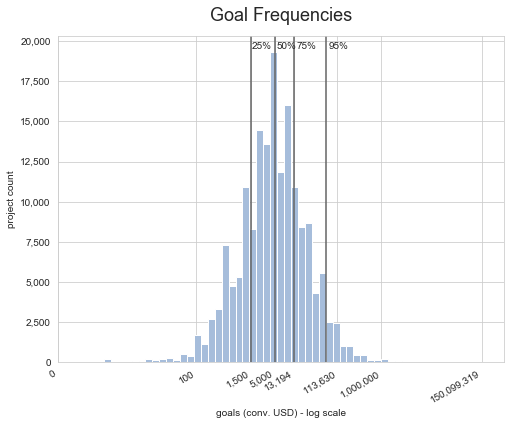

In [16]:
# settings
plt.figure(figsize=[8,6])
base_color = sns.color_palette("Blues_r")[0]

# create log scale and bin data 
log_data = np.log10(ks_compl.goal_hist_usd)
log_bin_edges = np.arange(0, log_data.max()+0.15, 0.15)

# plot histogram using binned log data 
plt.hist(log_data, bins = log_bin_edges, color="#a6bddb");

ax = plt.gca()
# annotate quantiles
for q, text in zip([goal_25, goal_50, goal_75, goal_95], ["25%", "50%", "75%", "95%"]):
    # calculate log quantile
    log_q = np.log10(q)
    ax.axvline(x=log_q, color='#636363', ymax=1, linestyle="-")
    ax.annotate(text, xy=(log_q*1.01, 19500),fontsize=10)

# labels and ticks
plt.title("Goal Frequencies", fontsize=18, pad=15)

format_yticks(20000, 2500)
plt.ylabel("project count")

x_ticks = [0.1, 100, goal_25, goal_50,  round(goal_75, 2), round(goal_975,2), 1000000, round(ks_compl['goal_hist_usd'].max()) ]
x_tick_labels = [format_num(x_tick) for x_tick in x_ticks]
plt.xticks(np.log10(x_ticks), x_tick_labels, rotation=30, ha='right')
plt.xlabel('goals (conv. USD) - log scale')

plt.show()

## The lower the goal the better
If creators want to keep at least a 50% chance, it appears to be advisable to stay below a benchmark of USD 10k. On average goals below USD 5k had a greater than 60% chance of succeeding. Very risk-averse creators may even choose to stick to goals below USD 1,5k.  

Creators seeking high funding may consider alternative investment possibilities to Kickstarter. 3 quarters of successful goals were below USD 9,6k anyways. The success chances of projects between USD 65k to 113k were only 20%. For even higher goals, success chances draw closer to zero.

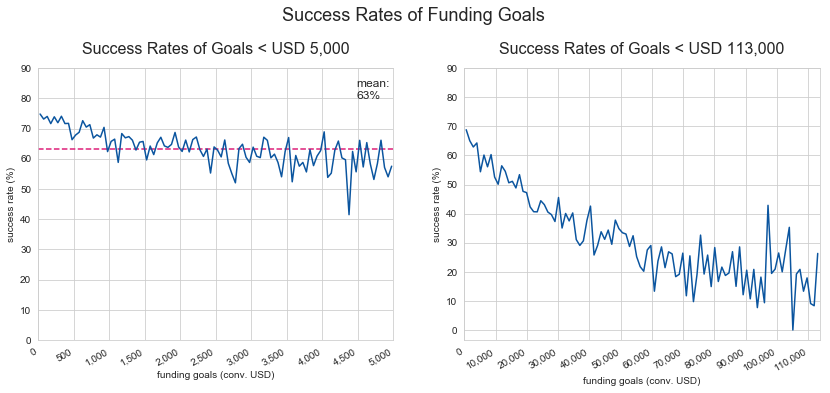

In [17]:
# utility to bin data
def bin_data(df):
    # create bin edges for goals
    bin_size = (df['goal_hist_usd'].max()-df['goal_hist_usd'].min()) / 100
    bins = np.arange(df['goal_hist_usd'].min(),df['goal_hist_usd'].max()+bin_size, bin_size)
    # create bin centers to plot them in their accurate positions
    # leave out the the last value, since it doesn't correspond to an actual bin center  
    bins_c = bins[:-1] + bin_size/2
    # Use cut function to bin values into discrete intervals to segment and sort data values into bins. 
    # for all goals
    goals_binned = pd.cut(df['goal_hist_usd'], bins, include_lowest = True)
    # successful goals
    goals_binned_success = pd.cut(df[df.status == 'successful']['goal_hist_usd'], bins, include_lowest = True)
    return {'total': goals_binned, 'success': goals_binned_success, 'bins': bins_c}

# utility to plot success rates
def plot_success_r(goals_binned, mean=True):
    # calculate success rate for every bin
    success_r = (goals_binned['success'].value_counts(sort=False) / goals_binned['total'].value_counts(sort=False)*100).values
    # plot success rates as adapted line plot to emphasize relative change
    plt.errorbar(x = goals_binned['bins'], y = success_r, color=goal_color)
    # plot success mean
    if mean:
        plt.axhline(success_r.mean(), color='#dd1c77', linestyle='--')
        plt.annotate("mean:\n" + str(int(round(success_r.mean()))) + "%", xy=(goals_binned['bins'].max()*0.9, 80), fontsize=12)

# settings
plt.figure(figsize=[14,5])
goal_50 = ks_compl['goal_hist_usd'].median()
goal_975 = ks_compl['goal_hist_usd'].quantile(q=0.975)

plt.subplot(1,2,1)
# plot low to moderately high goals
goals_binned = bin_data(ks_compl[ks_compl['goal_hist_usd'] < goal_50])
plot_success_r(goals_binned)

# ticks and labels
plt.title("Success Rates of Goals < USD " + format_num(goal_50), fontsize=16, pad=15)

locs = np.arange(0, goal_50+500, 500)
labels = [str(format_num(loc)) for loc in locs]
plt.xticks(locs, labels, rotation=30, ha='right')
plt.xlabel("funding goals (conv. USD)")
plt.xlim(0, goal_50)

plt.yticks(np.arange(0, 91, 10))
plt.ylabel("success rate (%)")

plt.subplot(1,2,2)
# plot low to extreme goals
goals_binned = bin_data(ks_compl[ks_compl['goal_hist_usd'] < goal_975])
plot_success_r(goals_binned, False)

# ticks and labels
plt.title("Success Rates of Goals < USD " + format_num(113000), fontsize=16, pad=15)

locs = np.arange(0, 130000+10000, 10000)
labels = [str(format_num(loc)) for loc in locs]
plt.xticks(locs, labels, rotation=30, ha='right')
plt.xlabel("funding goals (conv. USD)")
plt.xlim(0, goal_975)

plt.yticks(np.arange(0, 91, 10))
plt.ylabel("success rate (%)")

plt.suptitle("Success Rates of Funding Goals ", fontsize=18, y=1.05)
plt.show()        

## Successful projects realize an average surplus of 17.6%  

The plots illustrate that the surplus creators realize depends on the goal chosen. Roughly, the surplus rate above goal describes a u-form. For goals below USD 3,000 the surplus rate descended exponentially. The lower the goal chosen the higher was the surplus rate. Low goal projects typically realized a surplus of 40%, whereas goals between USD 1,5k to 13k made a median surplus of 11-12%. 

Creators seeking funding above USD 18k, were able to count on increasing surplus rates. In particular, goals from 45k up to 113k realized a median surplus of 26%. However, the surplus rates become less reliable as the volatility of pledges increases.

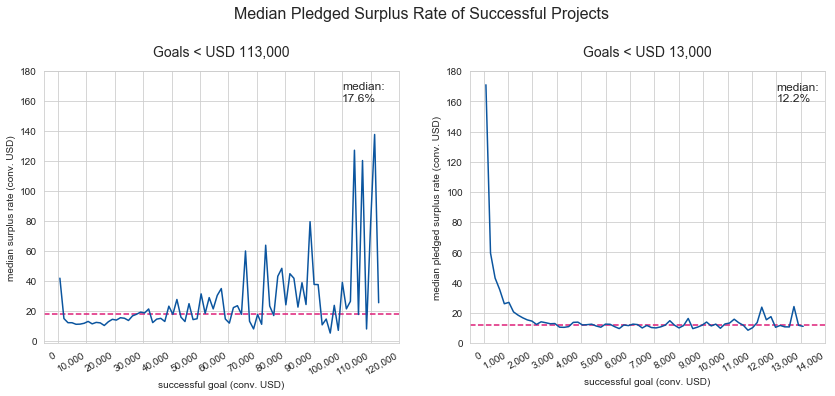

In [18]:
# settings
plt.figure(figsize=[14,5])

def binned_pledges(df, bin_count):
    # cluster goals
    bin_size = (df['goal_hist_usd'].max()-df['goal_hist_usd'].min()) / bin_count
    bin_edges = np.arange(df['goal_hist_usd'].min(), df['goal_hist_usd'].max()+bin_size, bin_size)
    bin_centers = bin_edges[:-1] + bin_size/2
    pd.set_option('mode.chained_assignment', None) # turn off warning
    df['goal_bin'] = pd.cut(df['goal_hist_usd'], bin_edges, labels=bin_centers)
    # calculate median surplus rate for every goal
    df_binned = df['surplus_r'].groupby([df.goal_bin]).median().reset_index()
    return df_binned

# calculate relative differences between goal and pledged of successful campaigns
ks_compl['surplus'] = ks_compl['pledged_hist_usd'] - ks_compl['goal_hist_usd'] 
ks_compl_95['surplus'] = ks_compl_95['pledged_hist_usd'] - ks_compl_95['goal_hist_usd'] 
ks_compl['surplus_r'] = abs(ks_compl['surplus'] / ks_compl['goal_hist_usd']) *100 
ks_compl_95['surplus_r'] = abs(ks_compl_95['surplus'] / ks_compl_95['goal_hist_usd']) *100 
ks_compl_success = ks_compl[ks_compl.status == 'successful']

# left plot: binned median pledges and respective binned goals 
plt.subplot(1,2,1)
# for successfull campaigns with goals below 95%-quantile 
ks_goal_975_s = ks_compl_success[ks_compl_success.goal_hist_usd < goal_975]
df_binned = binned_pledges(ks_goal_975_s, 80)
plt.errorbar(x = df_binned['goal_bin'], y = df_binned['surplus_r'], color=goal_color ) 
# annotate median
plt.axhline(df_binned.surplus_r.median(), color='#dd1c77', linestyle='--')
plt.annotate("median:\n" + str(round(df_binned.surplus_r.median(),1)) + "%", xy=(100000, 160), fontsize=12)

# ticks and labels
plt.title("Goals < USD 113,000", fontsize=14, pad=15)
locs = np.arange(0, 113000+10000, 10000)
labels = [str(format_num(loc)) for loc in locs]
plt.xticks(locs, labels, rotation=30, ha='right')
plt.xlabel("successful goal (conv. USD)")
format_yticks(180, 20)
plt.ylabel("median surplus rate (conv. USD)")

# right plot: binned median pledges vs. respective binned goals: moderately high goals (50% quantile)
plt.subplot(1,2,2)
goal_75 = ks_compl['goal_hist_usd'].quantile(q=0.75)
df_binned = binned_pledges(ks_compl_success[ks_compl_success.goal_hist_usd < goal_75], 70)
plt.errorbar(x = df_binned['goal_bin'], y = df_binned['surplus_r'], color=goal_color ) 
plt.axhline(df_binned.surplus_r.median(), color='#dd1c77', linestyle='--')
plt.annotate("median:\n" + str(round(df_binned.surplus_r.median(),1)) + "%", xy=(12000, 160), fontsize=12)

# ticks and labels
plt.title("Goals < USD 13,000", fontsize=14, pad=15)
locs = np.arange(0, goal_75+1000, 1000)
labels = [str(format_num(loc)) for loc in locs]
plt.xticks(locs, labels, rotation=30, ha='right')
plt.xlabel("successful goal (conv. USD)")
format_yticks(180, 20)
plt.ylabel("median pledged surplus rate (conv. USD)")

plt.suptitle("Median Pledged Surplus Rate of Successful Projects", fontsize=16, y=1.06)
plt.show()


## The higher a goal the higher the average pledge per backer
The higher a goal the higher was the average amount each supporter invested. For successful low goal projects (below USD 1,5k) the median pledged per backer was USD 37. Moderately high goals generate a median of USD 83. Successful very high goal projects generate the highest median funding per backer: USD 151. 

Creators may consider this behavior when defining the rewards for pledges.

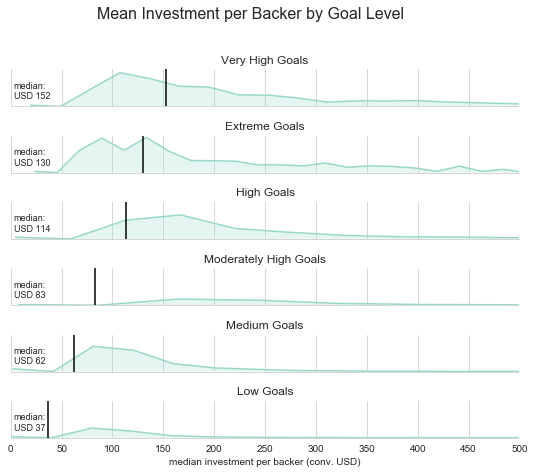

In [19]:
# calculate the pledged investment per backer
ks_compl['pledged_backer_r'] = ks_compl['pledged_hist_usd'] / ks_compl['backers_count']
ks_compl_95['pledged_backer_r'] = ks_compl_95['pledged_hist_usd'] / ks_compl_95['backers_count']
ks_compl_success = ks_compl[ks_compl.status == "successful"]

# calculate median per goal level
group_means = ks_compl_success.groupby(['goal_level']).median()
group_order = group_means.sort_values(['pledged_backer_r'], ascending = False).index[:-1]

# facet plots per goal levels 
g = sns.FacetGrid(data = ks_compl_success, row = 'goal_level', height = 1, aspect = 8,
                 row_order = group_order)

# plot distribution as kernel density estimate
g.map(sns.kdeplot, 'pledged_backer_r', shade = True, bw=0.1, color='#99d8c9')
plt.xlim(0, 500)

# annotate median per goal level
def vertical_mean_line(data, **kwargs):
    plt.axvline(data.median(),**kwargs)  
    plt.text(3, 0.001, "median:\nUSD " + format_num(data.median()), fontsize=9)
g.map(vertical_mean_line, 'pledged_backer_r',  color='black' )

# labels and ticks
for ax, title in zip(g.axes.flat, group_order):
    ax.set_title(title.title() + " Goals")

# remove the y-axes
g.set(yticks=[])
g.despine(left=True)

format_xticks(500, 50)
plt.xlabel("median investment per backer (conv. USD)")

plt.suptitle("Mean Investment per Backer by Goal Level", fontsize=16, y=1.09)
plt.show()

## Kickstarter's promotional support is extremely relevant for success
In the last 10 years, only the projects that were supported by Kickstarter succeeded. Since 2018, on average, 54% of the projects were spotlighted on Kickstarter's landing page (and optionally on Kickstarter's social media channels). 11% of completed projects were fully supported. Meaning, they got picked by staff and were awarded the "Projects We Love" badge.  

All crowdfundings that were not announced on Kickstarter's landing page failed. This includes a few campaigns that got the "Projects We Love" badge, but were not spotlighted in any way. 

Being fully featured by Kickstarter also drove the total collected funding. Projects which received the 'Projects We Love' badge in addition to being spotlighted on the landing page, had more than a double the number of supporters, which resulted in 2 to 2.5 times higher funding compared to campaigns that were only spotlighted. 

Generally, Kickstarter tends to support projects with lower goals. Spotlighted projects on average sought a goal of USD 3,4k. Creators who intend to collect higher funding should aim for the badge in addition to being featured on the website. Fully supported projects realized a median goal of USD 7,1k.

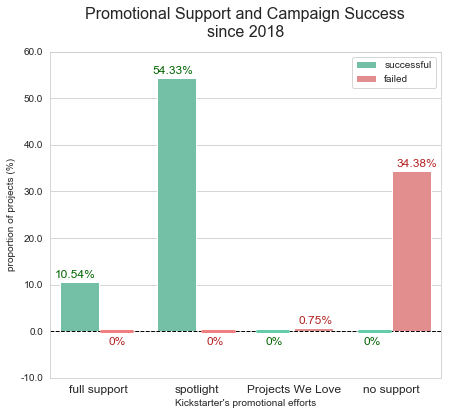

In [20]:
# only consider projects since 2018 due to latest changes in promotional behavior
ks_compl_latest = ks_compl[ks_compl.deadline.dt.year > 2017]

# settings
plt.figure(figsize = [7, 6])

# order
status_order = ks_compl_latest.status.value_counts().index
feat_order = ['full support', 'spotlight', 'Projects We Love', 'no support']

# get proportion of most common group - successful projects
# and calculate relative values
n_points = ks_compl_latest.shape[0]
max_feat = ks_compl_latest['featured'].value_counts().max()
max_feat_prop = max_feat / n_points
max_status = ks_compl_latest['status'].value_counts().max()
max_status_prop = max_status / n_points

# clustered bar chart featured categories vs. project status
sns.countplot(data = ks_compl_latest, x = 'featured', hue = 'status',
             order = feat_order, hue_order = status_order, color=sns.set_palette(status_colors[1:]))

# add zero line
ax = plt.gca()
ax.axhline(linewidth=1, color='black', y=0.1, ls="--")

# annotate percentages and add empty categories
i = -0.5
xmin=0.13
k=-0.1
annot_color = ['darkgreen', 'darkgreen', 'firebrick', 'firebrick']
bar_color = [ cust_green, cust_green, cust_red, cust_red]
for j, feat in enumerate(feat_order):
    if j == 2:
        i += 0.5
        color_i = 'firebrick'
        xmin -= 0.12
        k = 0.29
    rate = (ks_compl_latest.featured.value_counts()[feat] / n_points) * 100
    plt.text(i+0.05, ks_compl_latest.featured.value_counts()[feat]+300, str(round(rate, 2)) + "%", 
    fontsize=12, color=annot_color[j])
    ax.axhline(linewidth=3, color=bar_color[::-1][j], y=0.1, xmin=xmin, xmax=xmin+0.08)
    plt.text(j-k, -1000, "0%", fontsize=12, color=annot_color[::-1][j])
    xmin+=0.26
    i+=1

# label and title
# plt.legend(loc=9, bbox_to_anchor=(0.6, 1))
plt.legend(loc=1)
plt.title("Promotional Support and Campaign Success\nsince 2018", fontsize=16, pad=15)
plt.xlabel("Kickstarter's promotional efforts")
plt.xticks(fontsize=12)

# generate proportion tick marks
ylocs = np.arange(-0.1, 0.6+0.1, 0.1)
ylabels = ['{:0.1f}'.format(yloc*100) for yloc in ylocs]
plt.yticks(ylocs * n_points,ylabels )
plt.ylabel("proportion of projects (%)")

plt.show()

In [21]:
ks_compl_95_latest = ks_compl_95[ks_compl_95.deadline.dt.year > 2017]
ks_compl_95_latest_full = ks_compl_95_latest[ks_compl_95_latest.featured == 'full support']
print(ks_compl_95_latest_full.pledged_hist_usd.median())
ks_compl_95_latest_spot = ks_compl_95_latest[ks_compl_95_latest.featured == 'spotlight']
print(ks_compl_95_latest_spot.pledged_hist_usd.median())

7127.050999833176
3449.0


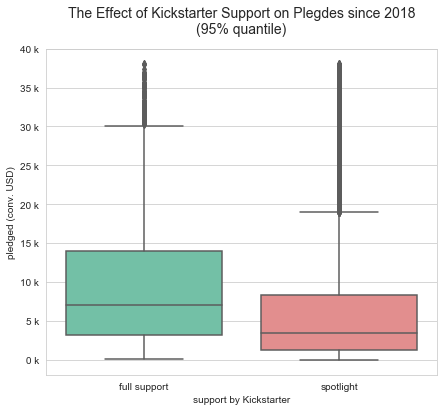

In [22]:
# settings
plt.figure(figsize = [7, 6])

# boxplot of latest 95 quantile data to reduce strong skew caused by outliers 
ax = sns.boxplot(data = ks_compl_95_latest, x = 'featured', 
                 y = 'pledged_hist_usd', order=feat_order[:2])

# ticks and labels
ylocs = np.arange(0, pledged_95+5000, 5000)
ylabels = [str(int(yloc/1000)) + " k" for yloc in ylocs]
plt.yticks(ylocs, ylabels)
plt.xlabel("support by Kickstarter")
plt.ylabel("pledged (conv. USD)")
plt.title("The Effect of Kickstarter Support on Plegdes since 2018\n(95% quantile)", fontsize=14, pad=15)
plt.show()

## The time of year matters
The time of the year on average affected the general success chances, investor counts and collected funding. Considering all factors, I found the best chances are in December. Generally, October to December and April to July were the most promising months to run a campaign. January to March performed suboptimally. 

November was the safest bet for every creator whose primary goal was to end a campaign successfully. Those creators should avoid running a campaign in January since success rates were roughly 10% lower. Creators who seek high funding had the best chances in December or June and should avoid January to March.

In [23]:
# utility function to create a median values of specific features grouped by months
def group_data(df, feature):
    # select by successful and failed projects
    df_s  = df[df.status == "successful"]
    df_f  = df[df.status == "failed"]
    
    # Due to strong skew, I use median instead of average to calculate the number of backers
    feat_total = df[feature].groupby([df.deadline.dt.month]).median()
    feat_success = df_s[feature].groupby([df_s.deadline.dt.month]).median()
    feat_fail = df_f[feature].groupby([df_f.deadline.dt.month]).median()

    # create data frame
    df_months_95 = pd.DataFrame({'total': feat_total.values, 
                                 'successful': feat_success.values, 
                                 'failed': feat_fail.values})
    
    # change order of data, bring January to center position
    return df_months_95[6:].append(df_months_95[:6]).reset_index(drop=True)

In [24]:
# only consider data after 2015 to today - April 2019, because values were most stable
ks_15_19  = ks_compl[ks_compl.deadline.dt.year > 2014 ] 
ks_95_15_19  = ks_compl_95[ks_compl_95.deadline.dt.year > 2014] 

# count projects ending each month
counts =  ks_15_19.deadline.groupby([ks_15_19.deadline.dt.month]).count()

# get average by dividing Jan-Apr months by 5 other months by 4 
proj_counts = [count / 5 for count in counts[:4]] + [count / 4 for count in counts[4:]]

# calculate average monthly project counts of successful and failed projects by month
df_success_15  = ks_15_19[ks_15_19.status == "successful"]
counts =  df_success_15.deadline.groupby([df_success_15.deadline.dt.month]).count()
# divide Jan-Apr by 5 and other months by 4
success_proj_counts = [count / 5 for count in counts[:4]] + [count / 4 for count in counts[4:]]

df_fail_15  = ks_15_19[ks_15_19.status == "failed"]
counts =  df_fail_15.deadline.groupby([df_fail_15.deadline.dt.month]).count()
failed_proj_counts = [count / 5 for count in counts[:4]] + [count / 4 for count in counts[4:]]

# create combined dataframe
ks_months = pd.DataFrame({'avg_total': proj_counts, 
                          'avg_success': success_proj_counts, 
                          'avg_failed': failed_proj_counts})

# As the interesting behavior is happening in January, I want to shift January to the middle of the plot.
# Rearange ordering so that July is at the frst place
ks_months_sorted = ks_months[6:].append(ks_months[:6]).reset_index(drop=True)

# create new columns of avg monthly avg success and failure rates 
ks_months_sorted['success_r'] = [ks_months_sorted.iloc[i][1] *100/ ks_months_sorted.iloc[i][0] for i in range(12)]
ks_months_sorted['failure_r'] = [ks_months_sorted.iloc[i][2] *100/ ks_months_sorted.iloc[i][0] for i in range(12)]

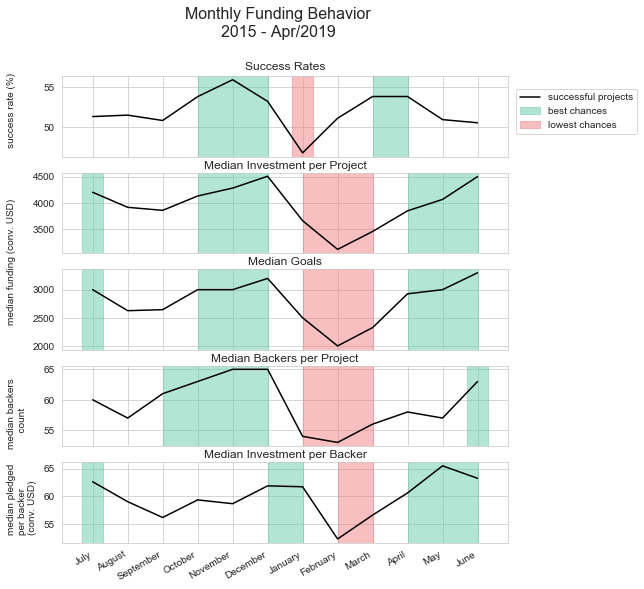

In [25]:
# plot median success rates, goals, pledges, backers counts and pledge-backer ratio 
# grouped by months on one axis
fig, ax = plt.subplots(5, 1, sharex=True)

# ticks and labels
xlocs = np.arange(0,12)
plt.xticks(xlocs, months, rotation=30, ha='right');

# plot success rates
ax[0].plot(xlocs, ks_months_sorted['success_r'], color='black')


# plot features
for i, feature in enumerate(['pledged_hist_usd', 'goal_hist_usd', 'backers_count', 'pledged_backer_r']):
    ks_months_95_sorted = group_data(ks_95_15_19, feature)
    ax[i+1].plot(xlocs, ks_months_95_sorted['successful'], color='black', label="successful projects")
    plt.subplots_adjust(bottom=-0.2)
    
# highlight best months
# success rates: highlight positively Oct-Dec and March/April
ax[0].axvspan(3, 5,color=cust_green, alpha=0.5, label="best chances")
ax[0].axvspan(8, 9, color=cust_green, alpha=0.5)

# pledged_hist_usd: highlight positively May, June, July and Oct-Dec
ax[1].axvspan(3, 5,  color=cust_green, alpha=0.5)
ax[1].axvspan(9, 11, color=cust_green, alpha=0.5)
ax[1].axvspan(-0.3, 0.3,  color=cust_green, alpha=0.5)

# goal_hist_usd: highlight positively Apr-July and Oct-Dec
ax[2].axvspan(9, 11, color=cust_green, alpha=0.5)
ax[2].axvspan(-0.3, 0.3,  color=cust_green, alpha=0.5)  
ax[2].axvspan(3, 5, color=cust_green, alpha=0.5)

# backers counts: highlight positively June/July and Sept-Dec   
ax[3].axvspan(10.7, 11.3,  color=cust_green, alpha=0.5)
ax[3].axvspan(2, 5, color=cust_green, alpha=0.5)

# pledged per backer: highlight positively Apr-July and Dec/Jan
ax[4].axvspan(9, 11, color=cust_green, alpha=0.5)
ax[4].axvspan(-0.3, 0.3,  color=cust_green, alpha=0.5)  
ax[4].axvspan(5, 6, color=cust_green, alpha=0.5)

# highlight worst months
ax[0].axvspan(5.7, 6.3,  color=cust_red, alpha=0.5, label="lowest chances")  # success rates - January
ax[1].axvspan(6, 8, color=cust_red, alpha=0.5) # pledged hist usd - Jan-Mar
ax[2].axvspan(6, 8, color=cust_red, alpha=0.5) # goals hist usd - Jan-Mar
ax[3].axvspan(6, 8, color=cust_red, alpha=0.5) # backers count - Jan-Mar
ax[4].axvspan(7, 8, color=cust_red, alpha=0.5) # pledged per backer - Feb-Mar

# figure size
fig.set_size_inches(8, 6);

# ticks and labels
fig.text(0.03, 0.8, "success rate (%)", va='center', rotation='vertical')
fig.text(0.03, 0.45, "median funding (conv. USD)", va='center', rotation='vertical')
fig.text(0.03, 0.1, "median backers\n      count", va='center', rotation='vertical')
fig.text(0.03, -0.1, "median pledged\nper backer\n(conv. USD)", va='center', rotation='vertical')

fig.suptitle('Monthly Funding Behavior\n2015 - Apr/2019', y=1.04, fontsize=16 )
ax[0].set_title('Success Rates', fontsize=12)
ax[1].set_title('Median Investment per Project', pad=4, fontsize=12)
ax[2].set_title('Median Goals', pad=4, fontsize=12)
ax[3].set_title('Median Backers per Project', pad=4, fontsize=12)
ax[4].set_title('Median Investment per Backer', pad=4, fontsize=12)

plt.xticks(xlocs, months, rotation=30, ha='right');
plt.legend(["successful projects", "best chances", "lowest chances"], loc=1,  
           bbox_to_anchor=(1.3, 5.7)).legendHandles[2].set_color(cust_red)

plt.show()


## The funding duration is 30 days
Although creators are free to choose their funding duration, it seems to be universally accepted to run a campaign within a period of roughly 30 days. It would seem natural to assume that a longer time frame would allow projects to increase their chances of success and collect a higher funding. However, I found that longer durations are not rewarded with success. In fact, campaign periods ranging between 15 to 32 days were generally linked with the best chances.

The capital requirements may affect the chances of success though. The average funding durations appear to be prolonged when the goals was set higher. Successful goals under USD 1,5k had a mean funding duration of 28 days. Successful very high goal projects (USD 13k - 65k) were able to extend the funding duration by one week (35 days) without loosing chances of success.

The second most popular period of 60 days turned out to be not advisable since it's associated with the lowest chances.

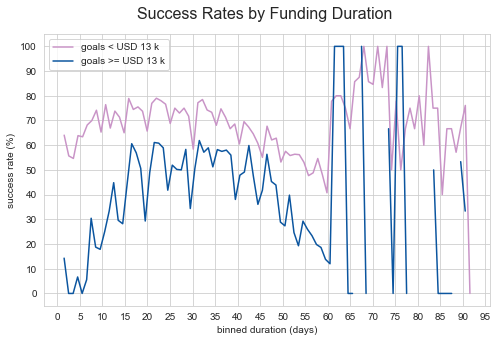

In [26]:
# settings
plt.figure(figsize=[8,5])

# utility to cluster duration
def binned_duration(df, bin_count):
    # cluster duration
    bin_size = (df['duration_days'].max()-df['duration_days'].min()) / bin_count
    bin_edges = np.arange(df['duration_days'].min(), df['duration_days'].max()+bin_size, bin_size)
    bin_centers = bin_edges[:-1] + bin_size/2
    pd.set_option('mode.chained_assignment', None) # turn off warning
    df['duration_bin'] = pd.cut(df['duration_days'], bin_edges, labels=bin_centers)
    return df

# calculate success rate for every bin and plot
def plot_success_r(df_binned):
    # calculate success rate for every bin
    success_r = (df_binned[df_binned.status == 'successful']['duration_bin'].value_counts(sort=False)\
                 / df_binned['duration_bin'].value_counts(sort=False)*100).values
    plt.errorbar(x = df_binned['duration_bin'].value_counts(sort=False).index, 
                 y = success_r, color=sns.set_palette([pledged_color, goal_color]))

# plot low to moderately high goals
df_duration_binned = binned_duration(ks_compl[ks_compl.goal_hist_usd < goal_75], 90)
plot_success_r(df_duration_binned)

# plot rate above moderately high goals
df_duration_binned = binned_duration(ks_compl[ks_compl.goal_hist_usd >= goal_75], 90)
plot_success_r(df_duration_binned)

# ticks and labels
plt.title("Success Rates by Funding Duration ", fontsize=16, pad=15)
plt.xticks(np.arange(0, 95+5, 5))
plt.xlabel("binned duration (days)")
plt.yticks(np.arange(0, 100+1, 10))
plt.ylabel("success rate (%)")
plt.legend(['goals < USD 13 k', 'goals >= USD 13 k'])
plt.show()

## The most valuable categories
I identified the most valuable project categories by depicting pledges against success rates. Accordingly, the most valuable campaigns were:  

1) Design, in particular Product Design  
2) Games, in particular Video Games and Tabletop Games  
3) Film & Video Documentaries 

**Tech and food projects are most likely to fail but realize the highest total funding.** 
Even though they are among the most popular categories, gadgets, hard- and software and web projects had low chances of success. In addition to technology ventures, I found 3 food subcategories among the ventures with the lowest chances: small batch, drinks and restaurants. We can attribute their high capital requirements to their poor success chances. It's important to say that higher failure rates do not necessarily imply that Kickstarter is generally a bad place for these types of projects. On the positive side, once successful, tech campaigns generated the highest median pledges of plus USD 22k. 

**Universal category names are more likely to succeed.**  
The top chances in popular project categories show a tendency to not have subcategories. Publishing, comics, film & video, art and music performed generally well they were communicated universally, instead of niche topics.

In [27]:
# utility to calculate median goals and create dataframe
def calc_med_goals_by(category):
    ks_cat_median = ks_compl.groupby(['status', category]).median()['goal_hist_usd']
    ks_cat_median = ks_cat_median.reset_index(name = 'goal_median')
    ks_cat_median = ks_cat_median.pivot(index = category, columns = 'status',
                            values = 'goal_median')
    ks_cat_median.rename(index=str, 
                     columns={'failed': 'med_goal_fail', 'successful': 'med_goal_success'}, 
                     inplace=True)
    # calculate median pledged
    med_cat_pledged = ks_compl.groupby(['status', category]).median()['pledged_hist_usd']
    med_cat_pledged = med_cat_pledged.reset_index(name = 'med_pledged')
    med_cat_pledged = med_cat_pledged.pivot(index = category, columns = 'status',
                            values = 'med_pledged')

    # add to dataframe
    ks_cat_median['med_pledged_fail'] = med_cat_pledged['failed']
    ks_cat_median['med_pledged_success'] = med_cat_pledged['successful']
    ks_cat_median = ks_cat_median.fillna(0).sort_values(by='med_pledged_success', ascending=True).reset_index()
    return  ks_cat_median

In [28]:
# utility to add success rates to data frame
def calc_cat_success(cat, df=ks_compl):
    success = df.groupby([cat,'status']).count()['project_id']
    success = success.reset_index(name='count')
    success = success.pivot(index=cat, columns='status', values='count')
    success = success.reset_index()
    # divide failed and success columns by category counts
    for status in ['failed', 'successful']:
        success[status] = (success[status] / df.groupby([cat]).count()['project_id'].values)*100
    return success

In [29]:
# utility function to plot multivariate plot of 2 numerical and 1 quantitative variable
def plot_facet_scatter_by(df, cat, headline, quadrants=True):
    g = sns.FacetGrid(data = df, hue = cat, height = 5, palette=category_colors)
    g.map(plt.scatter, 'successful', 'med_pledged_success')
    success_median = ks_cat_median['successful'].median()
    pledged_median = ks_cat_median['med_pledged_success'].median()
    
    ax = g.axes[0]
    if quadrants:
    # divide axis into 4 squares using a median
        ax[0].axvline(success_median, ls='--', label='median')
        ax[0].axhline(pledged_median, ls='--')

    # labels and ticks
    plt.title("Pledges by Success Rates\n" + headline, fontsize=16, pad=15)
    xlocs = np.arange(0, 100+10, 10)
    plt.xticks(xlocs)
    plt.xlabel("------ median success chances (%) ------>")
    format_yticks(df['med_pledged_success'].max(),5000)
    plt.ylabel("------ median pledged (convert. USD) ------>")

    leg = ax[0].legend(loc=1, bbox_to_anchor=(1.4, 1))
    leg.set_title('')
    plt.show()
    return g

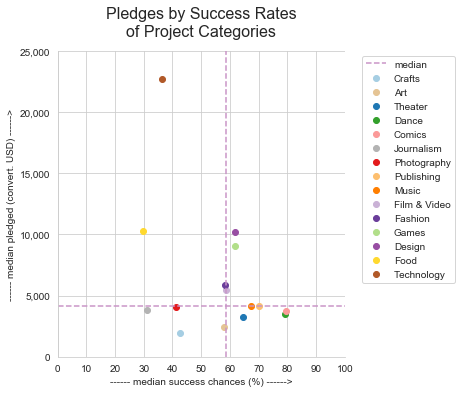

In [30]:
# return a dataframe of median goals and pledges grouped by status and category 
ks_cat_median = calc_med_goals_by('category')

# add success rates to data frame for each category and goal
df_cat_success = calc_cat_success('category')
ks_cat_median = ks_cat_median.merge(df_cat_success, on='category')

# plot pledged investment and success chance in a faceted scatterplot for each category
plot_facet_scatter_by(ks_cat_median, 'category', "of Project Categories");

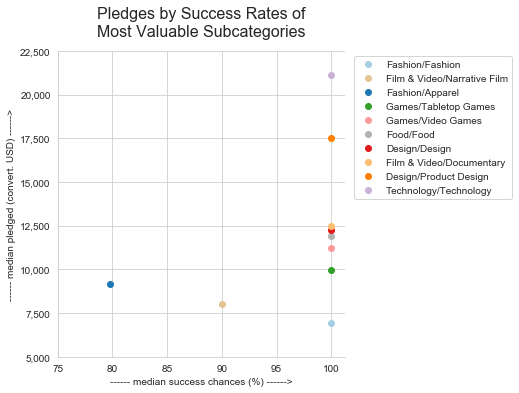

In [31]:
# return a dataframe of median goals and pledges grouped by status and subcategory 
ks_comb_cat_median = calc_med_goals_by('comb_cat')
# add success rates to data frame for each subcategory and goal
df_comb_cat_success = calc_cat_success('comb_cat')
ks_comb_cat_median = ks_comb_cat_median.merge(df_comb_cat_success, on='comb_cat')

# filter by best conditions: pledges above 5500 and +70% chance of success
df_best_types = ks_comb_cat_median[ks_comb_cat_median['med_pledged_success'] >= 6000]
df_best_types = df_best_types[df_best_types.successful > 70]

# scatterplot to identify best subcategories by median pledges and success rates
g = sns.FacetGrid(data = df_best_types, hue = 'comb_cat', height = 5, palette=category_colors);
g.map(plt.scatter, 'successful', 'med_pledged_success')

# labels and ticks
plt.title("Pledges by Success Rates of\nMost Valuable Subcategories", fontsize=16, pad=15)
format_xticks(100, 5, 75)
plt.xlabel("------ median success chances (%) ------>")
format_yticks(df_best_types['med_pledged_success'].max(), 2500, 5000)
plt.ylabel("------ median pledged (convert. USD) ------>")

plt.legend(loc=1, bbox_to_anchor=(1.6, 1))
plt.show()

> Once you're ready to finish your presentation, check your output by using
nbconvert to export the notebook and set up a server for the slides. From the
terminal or command line, use the following expression:
> > `jupyter nbconvert <file_name>.ipynb --to slides --post serve --template output_toggle`

> This should open a tab in your web browser where you can scroll through your
presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent
slide. Make sure you remove all of the quote-formatted guide notes like this one
before you finish your presentation!